# Predicción de niveles de radiación solar

### © Luis Antonio Correa Leyva

## Descripción del conjunto de datos y objetivos del proyecto

Se cuenta con un conjunto de datos de estaciones meteorológicas, en cada registro tenemos los siguentes campos:

* `estacionid`: Identificador para la estación que realizó el registro.
* `fecha` : Fecha y hora que se realizó el registro dado en el formato `YYYY-MM-DD HH-MM-SS`.
* `lat`: Latitud geográfica de la estación que realizó el registro.
* `lon`: Longitud geográfica de la estación que realizó el registro.
* `tamb`: Temperatura registrada en ese momento por la estación.
* `hum`: Nivel de humeda registrado en ese momento por la estación.
* `pres`: Presión atmosférica registrada en ese momento por la estación.
* `prec`: Desconocido.
* `rad`: Nivel de radiación solar registrado en ese momento por la estación.
* `vvien`: Velocidad del viento registrada en ese momento por la estación.
* `tipodered`: Desconocido, no relevante.

El objetivo que se persigue es poder predecir el nivel de radiación en varios momentos determinados dado que se conocen los registros de momentos anteriores. En una definición más formal el objetivo es predecir los niveles de radiación para instantes de tiempo $[t_1,t_2,...,t_n]$ dado que se conocen los registros de los instantes de tiempo $[t_{m}, t_{m+1}, ..., t_0]$ anteriores al momento $t_1$.

Para lograr este objetivo se propone emplear algoritmos de aprendizaje automático, para ser más exacto redes neuronales recurrentes, debido a que estos han demostrado en los últimos años tener un alto nivel de eficiencia y las redes neuronales recurrentes han sido diseñadas específicamente para el análisis y predicción de series temporales.

# I. Analisis de los datos

Dado que conocemos que cada registro del conjunto de datos contiene un campo para la `fecha` y que el objetivo que se persigue está relacionado con realizar predicciónes las cuáles deben estar ordenadas en el tiempo procederemos a realizar la carga de nuestros datos tomando como índice el campo `fecha` y ordenándolos en orden ascendente.

In [1]:
import pandas as pd

In [2]:
data = pd.read_csv('./data/meteo_galicia.csv', sep=';', parse_dates=['fecha'], decimal=',',
                 infer_datetime_format=True, low_memory=False, index_col='fecha').sort_index()

In [3]:
data

,estacionid,lat,lon,tamb,hum,pres,prec,rad,vvien,tipodered
fecha,,,,,,,,,,
2019-01-01 00:10:00,20284,42.4044,-8.6730,5.4,0,1022.0,0.0,0.0,0.7,OFICIAL
2019-01-01 00:10:00,20233,42.3554,-7.0086,7.3,0,892.1,0.0,0.0,3.5,OFICIAL
2019-01-01 00:10:00,20218,43.1626,-7.2826,9.2,0,955.0,0.0,0.0,0.0,OFICIAL
2019-01-01 00:10:00,20217,42.7071,-7.0471,8.5,0,882.5,0.0,1.0,6.3,OFICIAL
2019-01-01 00:10:00,20221,43.5407,-7.0830,5.3,0,1027.0,0.0,0.0,2.8,OFICIAL
...,...,...,...,...,...,...,...,...,...,...
2019-06-01 19:40:00,20249,42.2987,-7.5907,25.0,0,909.0,0.0,402.0,2.0,OFICIAL
2019-06-01 19:40:00,20259,42.1630,-7.0896,27.0,0,922.0,0.0,374.0,3.0,OFICIAL
2019-06-01 19:40:00,20255,42.4631,-6.9295,30.0,0,NaN,0.0,378.0,0.0,OFICIAL


## Descripción de los datos

In [4]:
data.describe()

,estacionid,lat,lon,tamb,hum,pres,prec,rad,vvien
count,2.510008e+06,2.510008e+06,2.510008e+06,2.507533e+06,2510008.0,1.814653e+06,2.509794e+06,2.499161e+06,2.507539e+06
mean,2.023039e+04,4.266182e+01,-8.022871e+00,8.994252e+00,0.0,9.677706e+02,6.805140e-03,1.167266e+02,2.144441e+00
std,4.163865e+01,4.825840e-01,6.507180e-01,5.504882e+00,0.0,4.522947e+01,2.574166e-01,2.210808e+02,3.068800e+00
min,2.015800e+04,4.189820e+01,-9.178300e+00,-2.800000e+01,0.0,7.000000e+02,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.019500e+04,4.231240e+01,-8.644000e+00,5.000000e+00,0.0,9.430000e+02,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.023100e+04,4.255520e+01,-8.066800e+00,9.000000e+00,0.0,9.750000e+02,0.000000e+00,0.000000e+00,1.000000e+00
75%,2.026600e+04,4.303590e+01,-7.439200e+00,1.200000e+01,0.0,1.004000e+03,0.000000e+00,1.220000e+02,3.000000e+00
max,2.030200e+04,4.373400e+01,-6.765200e+00,4.800000e+01,0.0,1.061000e+03,1.190000e+02,1.265000e+03,1.500000e+02


Con esta primera observación podemos percatarnos que el campo `hum` no posee ningún dato significativo ya que en todo momento está registrado como 0, se puede asumir que los sensores de las estaciones no están registrando esta información o simplemente que el campo no es relevante para resolver el problema en cuestión. Además podemos percatarnos que la información del campo `tipodered` no posee ningún valor numérico y que aparentemente su valor permance constante por lo que tampoco aporta información util para lograr el objetivo que se desea. Se procede a eliminar los campos innecesarios.

In [5]:
data = data.drop(columns=['tipodered', 'hum'])

### Las estaciones

Se conoce que cada registro se corresponde con una estación meteorológica en un instante de tiempo, y que cada estación está ubicada en un punto geográfico diferente de las demás, además se conoce que los niveles de radiación que es la variable que se quiere predecir varían en dependencia de la ubicacion geográfica. Por tanto sería de utilidad agrupar los registros por estaciones para así poder aplicar el algoritmo de aprendizaje que se determine a cada una de la estaciones por separado.

In [6]:
estaciones = [s for s in set(data['estacionid'])]

In [7]:
len(estaciones)

142

In [8]:
%%time
data_by_station = []

for s in estaciones:
    filter_station = data['estacionid'] == s
    data_station = data[filter_station].drop(columns=['estacionid', 'lat', 'lon'])
    d = data_station.describe()
    if d.rad['max'] != 0:
        data_by_station.append(data_station)

CPU times: user 3.16 s, sys: 39.1 ms, total: 3.2 s
Wall time: 3.21 s


In [9]:
len(data_by_station)

111

Como se observa hemos agregado un filtro extra antes de agregar los datos de cada estación a la lista `data_by_station` que contiene los registros agrupados de cada estación. Hemos especificado que solo se agreguen aquellas estación que han registrado al menos un nivel de radiación máximo diferente de cero, ya que los niveles de radiación solo toman valores positivos entonces las estaciones que registran un máximo de cero para los niveles de radiación son estaciones que no poseen información en este campo y por tanto no son de utilidad para el entrenamiento de nuestro algoritmo de aprendizaje. Como se puede ver en las instrucciónes anteriores hemos reducido la cantidad de estaciones de 142 a 111. Además hemos eliminado los campos de `estacionid`, `lat`, `lon` ya que por el momento no resultarán de utilidad para el análisis de los datos específicos de cada estación.

## Analisis gráfico

Para este análisis trabajaremos con los datos de una sola estación, podemos escoger una estación al azar de la lista pero en este caso seleccionaremos directamente la primera de la lista y asumiremos estos datos como datos de entrenamiento para la red neuronal.

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(rc={'figure.figsize': (16, 6)})

In [12]:
data_train = data_by_station[0]

In [14]:
data_train

,tamb,pres,prec,rad,vvien
fecha,,,,,
2019-01-01 01:00:00,11.6,1017.0,0.0,0.0,1.0
2019-01-01 01:10:00,10.9,1017.0,0.0,0.0,0.7
2019-01-01 01:30:00,10.3,1016.9,0.0,0.0,1.3
2019-01-01 01:40:00,10.0,1016.9,0.0,0.0,1.7
2019-01-01 02:00:00,10.2,1017.0,0.0,0.0,0.8
...,...,...,...,...,...
2019-06-01 18:30:00,27.0,1003.0,0.0,578.0,1.0
2019-06-01 18:40:00,26.0,1003.0,0.0,544.0,2.0
2019-06-01 19:00:00,26.0,1003.0,0.0,471.0,2.0


Si nos fijamos en nuestro índice `fecha` podemos percatarnos que el intervalo de tiempo entre registros no es constante, en algunos casos tenemos un intervalo de tiempo de 10min en otros de 20min y cabe la posibilidad de que existan otros intervalos mayores o menores. Por tanto procederemos en este caso a separar los registros por intervalos de tiempo de 10min, normalmente lo que se hace es rellenar los registros faltantes con el valor medio entre el registro anterior y posterior a este, pero en este caso estos registros son creados por estaciones meteorológicas podemos asumir que si faltan estos registros es porque en ese instante de tiempo no han ocurrido cambios con respecto al registro del instante anterior, entonces lo que haremos será rellenar estos instantes con los valores del registro anterior.

In [15]:
data_train = data_train.resample('10T').ffill().bfill()

Ahora procederemos a analizar correlación entre la variable correspondiente a los niveles de radiación (`rad`) y el resto de las variables. Debido a que nuestras variables se encuentran en unidades de medida diferentes con escala diferente procederemos a normalizarlas antes de mostrar graficamente sus valores en el tiempo. 

In [16]:
def normalize(data, key):
    return (data[key] - data[key].min()) / (data[key].max() - data[key].min())

In [17]:
rad = normalize(data_train, 'rad')
tamb = normalize(data_train, 'tamb')
pres = normalize(data_train, 'pres')
prec = normalize(data_train, 'prec')
vvien = normalize(data_train, 'vvien')

#### Relación gráfica entre Nivel de Radiación y Temperatura

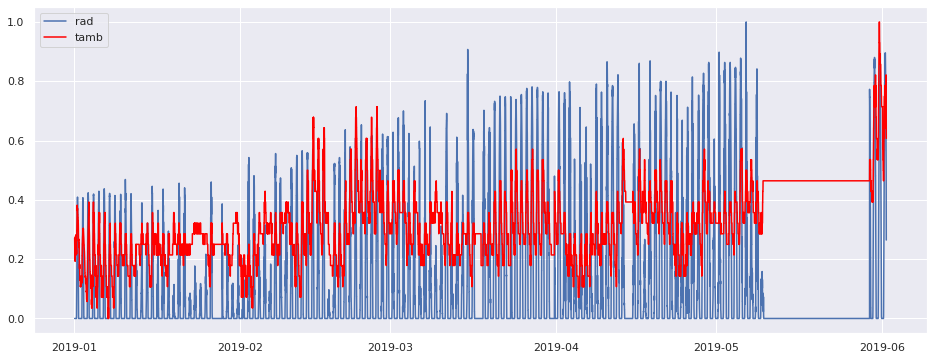

In [16]:
plt.plot(rad, label='rad')
plt.plot(tamb, label='tamb', color='red')
plt.legend()
plt.show()

#### Relación gráfica entre Nivel de Radiación y Presión

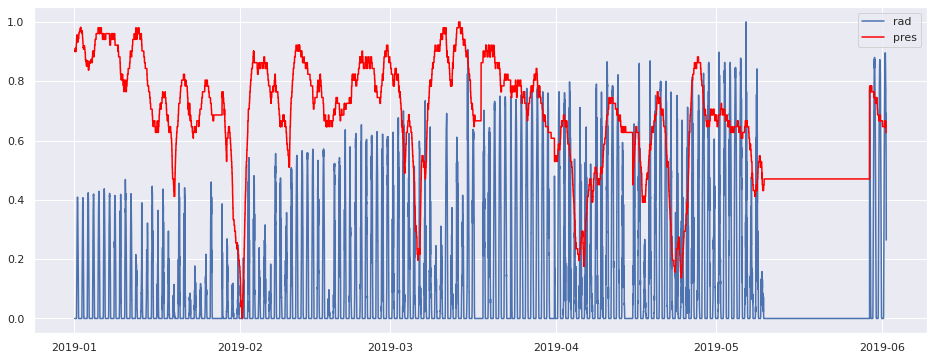

In [17]:
plt.plot(rad, label='rad')
plt.plot(pres, label='pres', color='red')
plt.legend()
plt.show()

#### Relación gráfica entre Nivel de Radiación y Prec (Desconocido)

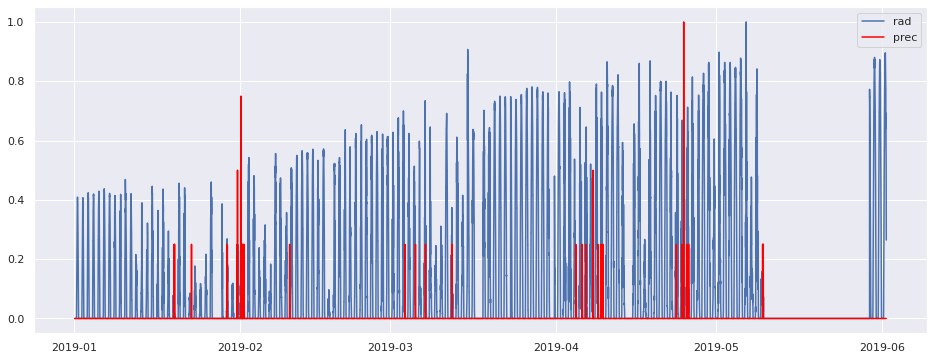

In [18]:
plt.plot(rad, label='rad')
plt.plot(prec, label='prec', color='red')
plt.legend()
plt.show()

#### Relación gráfica entre Nivel de Radiación y Velocidad del viento

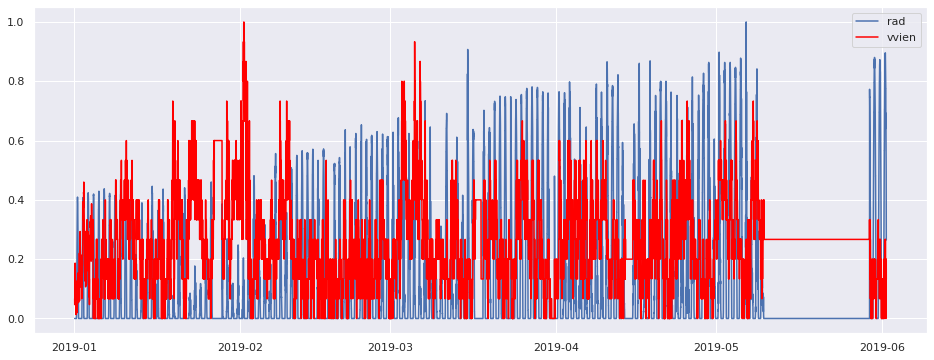

In [19]:
plt.plot(rad, label='rad')
plt.plot(vvien, label='vvien', color='red')
plt.legend()
plt.show()

Estos gráficos nos muestran el comportamiento de las variables en el tiempo y nos da una intuición de si existe relación entre las variables valorando la similitud entre los gráficos, sin embargo un método más eficiente puede ser utilizar funiones matemáticas para obtener numericamente el nivel de correlación entre las variables. Para este caso utilizaremos el método de correlación de `spearman`

In [24]:
print([i for i in range(0, len(data_train.columns))])
print([c for c in data_train.columns])

[0, 1, 2, 3, 4]
['tamb', 'pres', 'prec', 'rad', 'vvien']


In [26]:
data_train.corr(method='spearman')

,tamb,pres,prec,rad,vvien
tamb,1.000000,-0.283707,-0.025503,0.262111,0.035014
pres,-0.283707,1.000000,-0.069145,0.111469,-0.350531
prec,-0.025503,-0.069145,1.000000,0.003748,0.042201
rad,0.262111,0.111469,0.003748,1.000000,0.032882
vvien,0.035014,-0.350531,0.042201,0.032882,1.000000


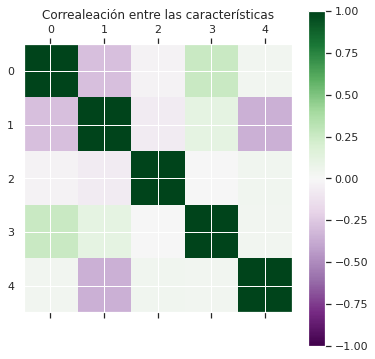

In [25]:
plt.matshow(data_train.corr(method='spearman'),vmax=1,vmin=-1,cmap='PRGn')
plt.title('Correaleación entre las características')
plt.colorbar()
plt.show()

Podemos observar en el gráfico anterior que existe un nivel de correlación aproximado de 0.26 entre la radiación y la temperatura y de 0.11 entre la radiación y la presión. Para el resto de las variables podemos asumir que el nivel de correlación es muy bajo y que realmente no aportan información útil para realizar las predicciónes de los niveles de radiación. Por tanto utilizaremos como variables extras para la predicción de los niveles de radiación `tamb` y `pres`, y procedemos a eliminar del conjunto de datos el resto de la variables.

In [27]:
data_train = data_train.drop(columns=['prec', 'vvien'])

In [28]:
data_train

,tamb,pres,rad
fecha,,,
2019-01-01 01:00:00,11.6,1017.0,0.0
2019-01-01 01:10:00,10.9,1017.0,0.0
2019-01-01 01:20:00,10.9,1017.0,0.0
2019-01-01 01:30:00,10.3,1016.9,0.0
2019-01-01 01:40:00,10.0,1016.9,0.0
...,...,...,...
2019-06-01 18:50:00,26.0,1003.0,544.0
2019-06-01 19:00:00,26.0,1003.0,471.0
2019-06-01 19:10:00,25.0,1003.0,402.0


# II Preparación del conjunto de datos para el entrenamiento de una red neuronal recurrente.